In [ ]:
# Get Tike working with PtychoNN
# Incraase network size

In [54]:
import sys
sys.path.append('/projects/hp-ptycho/wjudge/ptychonn/ptychonn/')
from ptychnn_theta import *
from skimage.transform import resize
import matplotlib.pyplot as plt
#from network_utils import *
#from tqdm import tqdm

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
def load_predicted_data(data_dir, scan_num):
    main_path = f"{data_dir}{scan_num}/"
    real_space = np.load(f"{main_path}recon_data.npy")
    preds_amp = np.load(f"{main_path}prediction_amp.npy")
    preds_phi = np.load(f"{main_path}prediction_phi.npy")
    pass

In [132]:
data_num = 204

real_space = np.load(f"/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{data_num}/recon_data.npy")
shape = real_space.shape
real_phi = np.angle(real_space)
real_phi = resize(real_phi, (shape[0], 128, 128))
real_amp = np.abs(real_space)
real_amp = resize(real_amp, (shape[0], 128, 128))
#preds_amp = np.load(f"/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{data_num}/pred_ampli.npy")
#preds_phi = np.load(f"/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{data_num}/pred_phase.npy")

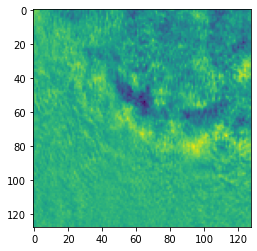

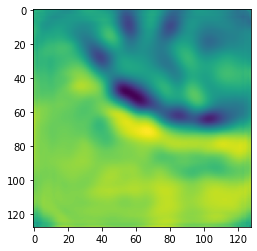

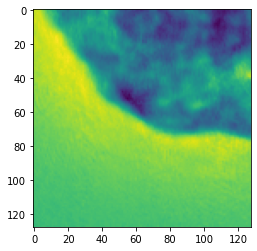

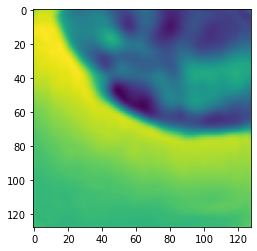

In [13]:
idx = 400

for d in [real_amp[idx], preds_amp[idx], real_phi[idx], preds_phi[idx]]:
    plt.imshow(d)
    plt.show()

In [133]:
base_path = '/projects/hp-ptycho/wjudge/'
data_path = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/eiger_4/S\
00000-00999/S00{data_num}/run_00{data_num}_000000000000.h5'

scan_path = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/scan_positions/scan_00{data_num}.dat'

scan = import_scan_paths(file=data_path, dat_file=scan_path, skiprows=2,
                         x_idx=2, y_idx=5, meter_convert=1e-6,
                          dist2det=2.97, ev=8800, detector_pixel_count=256, path_corr=[-1, -1])

pos = [scan[:, 1], scan[:, 0]]
pos = np.asarray(pos)
pos = pos / 2
pos.shape

(2, 943)

In [134]:
error = []
for data_num in range(data_num, data_num + 1):
    try:
        mat_loc = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/ptycho_reconstruct/catalyst/S00{data_num}/roi0_Ndp256/'
        mat_loc = determine_Niter(mat_loc, 0)
        probe = import_probe(mat_file=mat_loc, useH5=True)
        pb_weights = resize(np.abs(probe[0, 0, 0, :, :]), (128, 128))
        #probe.shape
    except Exception as ex:
        error.append((data_num, ex))
        
error

[]

In [135]:
pos_row = (pos[1]-np.min(pos[1]))
pos_col = (pos[0]-np.min(pos[0]))

print(pos_row.shape)

# integer position
pos_int_row = pos_row.astype(np.int32)
pos_int_col = pos_col.astype(np.int32)

pos_subpixel_row = pos_row - pos_int_row
pos_subpixel_col = pos_col - pos_int_col

(943,)


In [ ]:
dat_file = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/scan_positions/scan_00{data_num}.dat'
data_path = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/eiger_4/S00000-00999/S00{data_num}/run_00{data_num}_000000000000.h5'

In [156]:
725 + 138 - 2

861

In [ ]:
                     skiprows=2, x_idx=2, y_idx=5, meter_convert=1e-6, dist2det=2.97,
                     ev=8800, detector_pixel_count=256, path_corr=[-1, -1], ):
            
                center_x = 450 + 112 - 3
    center_y = 725 + 138 - 2
    crop_size = 256

In [159]:
scan_num = 280
base_path = '/projects/hp-ptycho/wjudge/'
setup_prediction(save_dir=f"{base_path}ptychonn/scan_dataml/",
                     scan_num=scan_num,
                     h5data_file=f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/eiger_4/S00000-00999/S00{scan_num}/run_00{scan_num}_000000000000.h5',
                     position_dat_file=f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/scan_positions/scan_00{scan_num}.dat',
                     dist2det=2.97, ev=8800, crop_size=256, center_x=559, center_y=861, 
                     skiprows=2, x_idx=2, y_idx=5,
                     meter_convert=1e-6, path_corr=[-1, -1])

In [154]:
def setup_prediction(save_dir, scan_num, h5data_file, position_dat_file,
                     dist2det, ev, crop_size, center_x, center_y, 
                     skiprows=2, x_idx=2, y_idx=5,
                     meter_convert=1e-6, path_corr=[-1, -1], ):
    
    # Scan Positions
    scan = np.loadtxt(position_dat_file,
                      unpack=False,
                      skiprows=skiprows)[:, (y_idx, x_idx)] * meter_convert
    scan = scan * np.array([path_corr])
    
    with h5py.File(h5data_file, 'a') as hdf:
        data = hdf.get('entry/data/eiger_4')
        pix_size = data.attrs["Pixel_size"]

    scan_positions = position_units_to_pixels(scan, dist2det,
                                              crop_size,
                                              pix_size[0][0], ev)

    # Diffraction Data
    with h5py.File(h5data_file, 'r') as hdf:
        data = hdf.get('entry/data/eiger_4')
        data = np.array(data)
        
    # Cropping
    size = int(crop_size / 2)
    if crop_size % 2 != 0:
        raise ValueError('Crop size is not an even number.')
    diffraction_data = data[:, center_x-size:center_x+size, center_y-size:center_y+size]
    
    # Saving
    np.save(f'{save_dir}{scan_num}/scan_pixel_positions.npy', scan_positions)
    np.save(f'{save_dir}{scan_num}/cropped_exp_diffr_data.npy', diffraction_data)

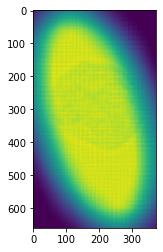

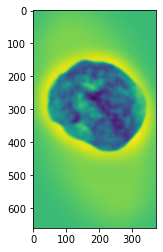

In [161]:
d = np.load('/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/280/prediction_amp.npy')
plt.imshow(d)
plt.show()

d = np.load('/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/280/prediction_phi.npy')
plt.imshow(d)
plt.show()

In [149]:
def load_predicted_data():
    pass

def stitch_predictions(data_dir, scan_num, predicted_data, pixel_div=1, H=128, W=128):
    pred_data = predicted_data.copy()
    
    main_path = f"{data_dir}{scan_num}/"
    scan_pos = np.load(f"{main_path}scan_pixel_positions.npy")
    scan_pos = np.asarray(scan_pos, dtype=object)
    pos = [scan_pos[:, 1], scan_pos[:, 0]]
    pos = np.asarray(pos, dtype=object)
    pos = pos / pixel_div
    
    pos_row = (pos[1]-np.min(pos[1]))
    pos_col = (pos[0]-np.min(pos[0]))

    # integer position
    pos_int_row = pos_row.astype(np.int32)
    pos_int_col = pos_col.astype(np.int32)

    pos_subpixel_row = pos_row - pos_int_row
    pos_subpixel_col = pos_col - pos_int_col
    
    hH = int(H/2)
    hW = int(W/2)

    composite_data = np.zeros((np.max(pos_int_row)+H,np.max(pos_int_col)+W),float)
    ctr = np.zeros_like(composite_amp)
    data_reshaped = resize(pred_data, (pred_data.shape[0], H, W))

    for i in range(pos_row.shape[0]):
        composite_data[pos_int_row[i]:pos_int_row[i]+H,pos_int_col[i]:pos_int_col[i]+H] += data_reshaped[i] * 1 
        #ctr[pos_int_row[i]:pos_int_row[i]+W,pos_int_col[i]:pos_int_col[i]+W] += pb_weights

    composite_data = composite_data[hH:-hH,hW:-hW]
    #ctr = ctr[hH:-hH,hW:-hW]
    return composite_data

In [ ]:
(943,)
(785, 501)
(943, 128, 128)
(657, 373)

In [150]:
data_dir = '/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/'
scan_num = 204

predicted_data = np.load(f'/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{scan_num}/patched_psi.npy')
predicted_data = np.angle(predicted_data)

out = stitch_predictions(data_dir, scan_num, predicted_data, pixel_div=2, H=128, W=128)

(943,)
(657, 373)
(943, 256, 256)
(943, 128, 128)


In [119]:
main_path = '/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/'
scan_num = 204
old_recon = np.load(f"{main_path}/{scan_num}/recon_data.npy")
new_recon = np.load(f"{main_path}/{scan_num}/patched_psi.npy")

In [ ]:
idx = 400
plt.imshow(np.angle(old_recon[idx]))
print(np.mean(np.angle(old_recon[idx]) ** 2))
plt.show()

plt.imshow(np.angle(new_recon[idx]))
print(np.mean(np.angle(new_recon[idx]) ** 2))
plt.show()

In [ ]:
predicted_data = np.load('/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/205/patched_psi.npy')
pred_ph = np.angle(predicted_data)

In [136]:
preds_amp = real_phi.copy()

H = 128
W = 128

hH = int(H/2)
hW = int(W/2)

composite_amp = np.zeros((np.max(pos_int_row)+H,np.max(pos_int_col)+W),float)

print(composite_amp.shape)
ctr = np.zeros_like(composite_amp)

data_reshaped = preds_amp.reshape(preds_amp.shape[0], H, W)
print(data_reshaped.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
#     weight_tmp = np.real(sub_shift.subpixel_shift(pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_amp[pos_int_row[i]:pos_int_row[i]+H,pos_int_col[i]:pos_int_col[i]+H] += data_reshaped[i] * 1 #* pb_weights
    ctr[pos_int_row[i]:pos_int_row[i]+W,pos_int_col[i]:pos_int_col[i]+W] += pb_weights
    
composite_amp = composite_amp[hH:-hH,hW:-hW]
ctr = ctr[hH:-hH,hW:-hW]
   
print(composite_amp.shape)

(785, 501)
(943, 128, 128)
(657, 373)


In [63]:
import tifffile as tif
image = tif.imread('/projects/hp-ptycho/wjudge/ptychonn/bicer_data/28idc_2021-10-12/ptycho_reconstruct/catalyst/S00289/roi0_Ndp256/MLs_L1_p1_g100_pc100_vp1_mm_MW10_2/O_phase_roi/O_phase_roi_Niter2000.tiff')

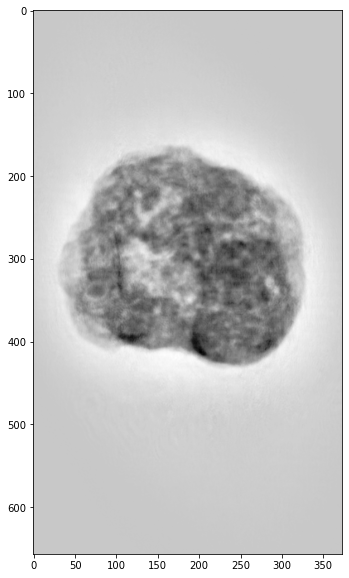

In [137]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(composite_amp, cmap='Greys_r')

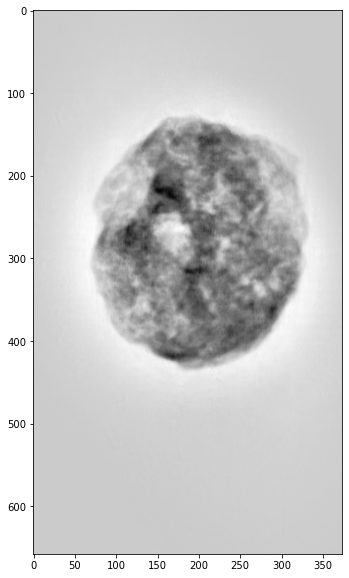

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(composite_amp, cmap='Greys_r')

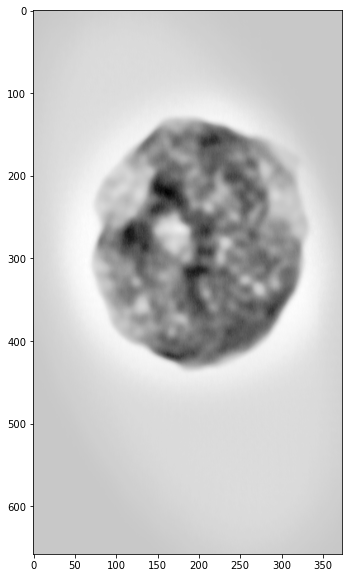

In [60]:
plt.figure(figsize=(10, 10))
plt.imshow(composite_amp, cmap='Greys_r')

In [26]:
#preds_phi = real_phi.copy()

composite_phase = np.zeros((np.max(pos_int_row)+H,np.max(pos_int_col)+W),float)
print(composite_phase.shape)

data_reshaped = preds_phi.reshape(preds_phi.shape[0],H,W)
print(data_reshaped.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_phase[pos_int_row[i]:pos_int_row[i]+H,pos_int_col[i]:pos_int_col[i]+W]  += data_reshaped[i] * pb_weights
    

composite_phase = composite_phase[hH:-hH,hW:-hW]

print(composite_phase.shape)

(787, 500)
(949, 128, 128)
(659, 372)


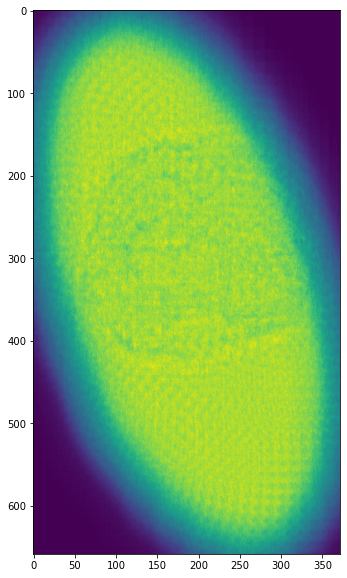

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(composite_amp, vmin=0,)